<a href="https://colab.research.google.com/github/kopalgarg/CSC2515/blob/main/HW3/Hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kopal Garg \
*Team: Rohan Deepak Ajwani, Yujie Chen* \

**Q3**

In [1]:
import zipfile
import numpy as np

import os

# (PLEASE DO NOT CHANGE) Set random seed:
np.random.seed(1746)

PREFIX = "digit_"

TEST_STEM = "test_"
TRAIN_STEM = "train_"

def check_and_extract_zipfile(filename, data_dir):
    os.chdir(data_dir)
    if os.path.isdir(data_dir) and not os.listdir(data_dir):
        pass
    else:
        zip_f = zipfile.ZipFile(filename, 'r')
        zip_f.extractall(data_dir)
        zip_f.close()

def load_data(data_dir, stem):
    """
    Loads data from either the training set or the test set and returns the pixel values and
    class labels
    """
    data = []
    labels = []
    for i in range(0, 10):
        path = os.path.join(data_dir, PREFIX + stem + str(i) + ".txt")
        digits = np.loadtxt(path, delimiter=',')
        digit_count = digits.shape[0]
        data.append(digits)
        labels.append(np.ones(digit_count) * i)
    data, labels = np.array(data), np.array(labels)
    data = np.reshape(data, (-1, 64))
    labels = np.reshape(labels, (-1))
    return data, labels

def load_all_data(data_dir, shuffle=True):
    '''
    Loads all data from the given data directory.

    Returns four numpy arrays:
        - train_data
        - train_labels
        - test_data
        - test_labels
    '''
    if not os.path.isdir(data_dir):
        raise OSError('Data directory {} does not exist. Try "load_all_data_from_zip" function first.'.format(data_dir))

    train_data, train_labels = load_data(data_dir, TRAIN_STEM)
    test_data, test_labels = load_data(data_dir, TEST_STEM)

    if shuffle:
        train_indices = np.random.permutation(train_data.shape[0])
        test_indices = np.random.permutation(test_data.shape[0])
        train_data, train_labels = train_data[train_indices], train_labels[train_indices]
        test_data, test_labels = test_data[test_indices], test_labels[test_indices]

    return train_data, train_labels, test_data, test_labels

def load_all_data_from_zip(zipfile, data_dir, shuffle=True):
    '''
    Loads all the data from the given zip file.

    Inputs:
        - zipfile: string path to a3digits zipfile
        - data_dir: path to directory to extract zip file
        - shuffle: whether to randomly permute the data (true by default)

    Returns four numpy arrays:
        - train_data
        - train_labels
        - test_data
        - test_labels
    '''

    check_and_extract_zipfile(zipfile, data_dir)
    return load_all_data(data_dir, shuffle)

def get_digits_by_label(digits, labels, query_label):
    '''
    Return all digits in the provided array which match the query label

    Input:
        - digits: numpy array containing pixel values for digits
        - labels: the corresponding digit labels (0-9)
        - query_label: the digit label for all returned digits

    Returns:
        - Numpy array containing all digits matching the query label
    '''
    assert digits.shape[0] == labels.shape[0]

    matching_indices = labels == query_label
    return digits[matching_indices]

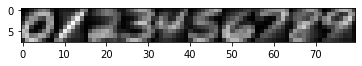

In [2]:
'''
Question 3.0 Skeleton Code

Here you should load the data and plot
the means for each of the digit classes.
'''

import numpy as np
# Import pyplot - plt.imshow is useful!
import matplotlib.pyplot as plt

def plot_means(train_data, train_labels):
  # TODO
    means = []
    for i in range(0, 10):
        i_digits = get_digits_by_label(train_data, train_labels, i)
        # Compute mean of class i
        mean_vec_size = len(i_digits[0])
        means.append([])
        for j in range(mean_vec_size):
            means[i].append(np.mean(i_digits[:, j])) 
        means[i] = np.array(means[i]).reshape(int(np.sqrt(mean_vec_size)),int(np.sqrt(mean_vec_size))) #8x8

    # Plot all means on same axis
    all_concat = np.concatenate(means, 1)
    plt.imshow(all_concat, cmap='gray')
    plt.show()

if __name__ == '__main__':
    train_data, train_labels, test_data, test_labels = load_all_data_from_zip('a3digits.zip', '/content/hw3_data/')
    plot_means(train_data, train_labels)

In [214]:
'''
Question 3.1 Skeleton Code

Here you should implement and evaluate the k-NN classifier.
'''

import numpy as np
# Import pyplot - plt.imshow is useful!
import matplotlib.pyplot as plt


class KNearestNeighbor(object):
    '''
    K Nearest Neighbor classifier
    '''

    def __init__(self, train_data, train_labels):
        self.train_data = train_data
        self.train_norm = (self.train_data**2).sum(axis=1).reshape(-1,1)
        self.train_labels = train_labels

    def l2_distance(self, test_point):
        '''
        Compute L2 distance between test point and each training point
        
        Input: test_point is a 1d numpy array
        Output: dist is a numpy array containing the distances between the test point and each training point
        '''
        # Process test point shape
        test_point = np.squeeze(test_point)
        if test_point.ndim == 1:
            test_point = test_point.reshape(1, -1)
        assert test_point.shape[1] == self.train_data.shape[1]

        # Compute squared distance
        test_norm = (test_point**2).sum(axis=1).reshape(1,-1)
        dist = self.train_norm + test_norm - 2*self.train_data.dot(test_point.transpose())
        return np.squeeze(dist)

    def query_knn(self, test_point, k):
        '''
        Query a single test point using the k-NN algorithm

        You should return the digit label provided by the algorithm
        '''
        digit = None

        # distances between the test point and each training point
        l2_dist = self.l2_distance(test_point)

        notie=False
        while notie==False:
          
          first_k = np.argpartition(l2_dist, k)[:k]
          freq = np.bincount(self.train_labels[first_k].astype('int'))
          digit = np.argwhere(freq == np.max(freq))
          # Q3.1 2 - tie breaking method (recall the function with k=k-1)
          if len(digit)>1:
            k=k-1
          else:
            notie=True
        return digit

def cross_validation(train_data, train_labels, k_range=np.arange(1,2)):
    '''
    Perform 10-fold cross validation to find the best value for k

    Note: Previously this function took knn as an argument instead of train_data,train_labels.
    The intention was for students to take the training data from the knn object - this should be clearer
    from the new function signature.
    '''
    from sklearn.model_selection import KFold
    import pandas as pd
    # documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

    fold = 10
    cv_result = np.zeros(2*k_range.max()).reshape(k_range.max(), 2)
    kf = KFold(n_splits=fold)
    kf.get_n_splits(train_data)

    # Loop over folds
    for train_index, test_index in kf.split(train_data):
        knn = KNearestNeighbor(train_data[train_index], train_labels[train_index])
        for k in k_range:
            # Evaluate k-NN
            # average train accuracy across folds
            ca, _ = classification_accuracy(knn, k, train_data[train_index], train_labels[train_index])
            cv_result[k-1,0]=cv_result[k-1,0] + ca/fold
            # average test accuracy across folds
            ca, _ = classification_accuracy(knn, k, train_data[test_index],  train_labels[test_index])
            cv_result[k-1,1]=cv_result[k-1,1] + ca/fold
  
    cv_result = pd.DataFrame(cv_result, columns=['train','test'])
    cv_result['train'] = 100*cv_result['train']
    cv_result['test'] = 100*cv_result['test']
    cv_result['K'] = k_range
    print(cv_result)
    return cv_result
    

def classification_accuracy(knn, k, eval_data, eval_labels):
    '''
    Evaluate the classification accuracy of knn on the given 'eval_data'
    using the labels
    '''
    count = 0
    preds = []
    for i in range(len(eval_data)):
      pred = knn.query_knn(eval_data[i], k)
      preds.append(pred)
      if pred == eval_labels[i]:
        count +=1
    
    acc = count / len(eval_labels)
    return acc, preds


train_data, train_labels, test_data, test_labels = load_all_data('/content/hw3_data')
knn = KNearestNeighbor(train_data, train_labels)

    # Q3.1 1a

train_acc_k1, _ =classification_accuracy(knn, 1, train_data, train_labels)
print("train_acc_k1: ", train_acc_k1*100)
test_acc_k1, _ =classification_accuracy(knn, 1, test_data, test_labels)
print("test_acc_k1: ", test_acc_k1*100)

    # Q3.1 1b
train_acc_k15, _ =classification_accuracy(knn, 15, train_data, train_labels)
print("train_acc_k15: ", train_acc_k15*100)
test_acc_k15, _ =classification_accuracy(knn, 15, test_data, test_labels)
print("test_acc_k15:", test_acc_k15*100)

train_acc_k1:  100.0
test_acc_k1:  96.875
train_acc_k15:  96.1
test_acc_k15: 95.89999999999999


         train       test   K
0   100.000000  96.428571   1
1   100.000000  96.428571   2
2    98.595238  96.528571   3
3    98.284127  96.471429   4
4    97.868254  96.214286   5
5    97.682540  96.157143   6
6    97.249206  95.971429   7
7    97.204762  95.871429   8
8    96.947619  95.685714   9
9    96.811111  95.642857  10
10   96.595238  95.457143  11
11   96.457143  95.357143  12
12   96.184127  95.071429  13
13   96.065079  94.914286  14
14   95.866667  94.800000  15


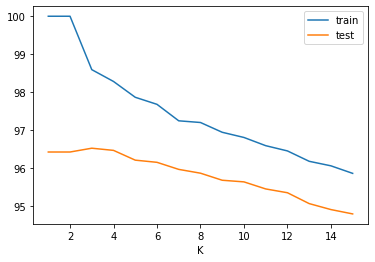

In [239]:
    # Q3.1 3  ## DONT RERUN - TAKES FOREVER (uncomment l8r)
'''
cv_result = cross_validation(train_data, train_labels, k_range=np.arange(1,16))
plt.plot(cv_result['K'], cv_result['train'], label = 'train')
plt.plot(cv_result['K'], cv_result['test'], label = 'test')
plt.xlabel("K")
plt.legend()
'''

In [246]:
# predictions using best K value

# K = 1 gives the best training accuracy, but the model is likely overfitting
_, y_pred_knn_k1 = classification_accuracy(knn, 1, test_data, test_labels)
y_pred_knn_k1 = np.ndarray.flatten(np.array(y_pred_knn_k1))
# The next best validation accuracy occurs when K = 3
best_K = 3
_, y_pred_knn_bestk = classification_accuracy(knn, best_K, test_data, test_labels)
y_pred_knn_bestk = np.ndarray.flatten(np.array(y_pred_knn_bestk))

Model Comparison

*MLP*

In [240]:
# MLP
from keras.models import Sequential
from keras.layers import Flatten,Dense
from keras.utils.np_utils import to_categorical   

train_labels_ohe = to_categorical(train_labels, num_classes=10)

model=Sequential()
input_layer= Flatten(input_shape=(8,8))
model.add(input_layer)
hidden_layer1=Dense(512,activation='relu')
model.add(hidden_layer1)
hidden_layer2=Dense(512,activation='relu')
model.add(hidden_layer2)
output_layer=Dense(10,activation='softmax')
model.add(output_layer)

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

model.fit(train_data.reshape(-1,8,8),train_labels_ohe,epochs=15, validation_split=.2)
model.save('mlp')

Epoch 1/15
175/175 [==============================] - 2s 8ms/step - loss: 0.5377 - accuracy: 0.8530 - val_loss: 0.2063 - val_accuracy: 0.9379
Epoch 2/15
175/175 [==============================] - 1s 7ms/step - loss: 0.1738 - accuracy: 0.9482 - val_loss: 0.1562 - val_accuracy: 0.9529
Epoch 3/15
175/175 [==============================] - 1s 7ms/step - loss: 0.1252 - accuracy: 0.9614 - val_loss: 0.1285 - val_accuracy: 0.9600
Epoch 4/15
175/175 [==============================] - 1s 7ms/step - loss: 0.0859 - accuracy: 0.9743 - val_loss: 0.1254 - val_accuracy: 0.9614
Epoch 5/15
175/175 [==============================] - 1s 7ms/step - loss: 0.0613 - accuracy: 0.9843 - val_loss: 0.1210 - val_accuracy: 0.9621
Epoch 6/15
175/175 [==============================] - 1s 7ms/step - loss: 0.0447 - accuracy: 0.9864 - val_loss: 0.1203 - val_accuracy: 0.9671
Epoch 7/15
175/175 [==============================] - 1s 7ms/step - loss: 0.0358 - accuracy: 0.9893 - val_loss: 0.1101 - val_accuracy: 0.9657
Epoch 

In [241]:
y_pred_mlp = model.predict(test_data.reshape(-1, 8,8))
y_pred_mlp_argmax = []
for i in range(y_pred_mlp.shape[0]):
  y_pred_mlp_argmax.append(int(np.argmax([y_pred_mlp[i]])))

*SVM*

In [45]:
# SVM Classifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics

# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 101)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [0.01, 0.001,0.0001],
                     'C': [1, 10, 100],
                  'kernel': ['rbf','poly','linear']}]
# specify model
model = SVC()

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,
                        n_jobs = -1)      

# fit the model
model_cv.fit(train_data, train_labels) 
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_
print('best_hyperparams', best_hyperparams)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
best_hyperparams {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [242]:
from sklearn.multiclass import OneVsRestClassifier

# best model
model = OneVsRestClassifier(
    SVC(C=100, gamma=.01, kernel='rbf', random_state=1,probability=True)
)

model.fit(train_data, train_labels)

y_pred_svm = model.decision_function(test_data)

y_pred_svm_argmax = []
for i in range(y_pred_svm.shape[0]):
  y_pred_svm_argmax.append(int(np.argmax([y_pred_svm[i]])))

*AdaBoost*

In [53]:
# AdaBoost Classifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

ada = AdaBoostClassifier()

hyper_params = [ {'learning_rate': [0.01, 0.02, 0.05, 0.001],
                     'n_estimators': [50, 100, 150, 200]}]

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = ada, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,
                        n_jobs = -1)   

model_cv.fit(train_data, train_labels)

best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_
print('best_hyperparams', best_hyperparams)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
best_hyperparams {'learning_rate': 0.05, 'n_estimators': 200}


In [243]:
model = AdaBoostClassifier(n_estimators=200, 
                           learning_rate=0.05, random_state=1)

model.fit(train_data, train_labels)

y_pred_ada= model.predict_proba(test_data)

y_pred_ada_argmax = []
for i in range(y_pred_ada.shape[0]):
  y_pred_ada_argmax.append(int(np.argmax([y_pred_ada[i]])))

*Model Comparison*

In [247]:
from sklearn.preprocessing import label_binarize
import sklearn
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

classes = [0,1,2,3,4,5,6,7,8,9]
n_classes = len(classes)
y_test = label_binarize(test_labels, classes=classes)
y_pred_mlp = label_binarize(y_pred_mlp_argmax, classes=classes)
y_pred_svm = label_binarize(y_pred_svm_argmax, classes=classes)
y_pred_ada = label_binarize(y_pred_ada_argmax, classes=classes)
y_pred_knn_k1 = label_binarize(y_pred_knn_k1, classes=classes)
y_pred_knn_bestk = label_binarize(y_pred_knn_bestk, classes=classes)


In [236]:
def roc(y_test, y_score):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  plt.figure()
  lw = 2
  plt.plot(
      fpr[2],
      tpr[2],
      color="darkorange",
      lw=lw,
      label="ROC curve (area = %0.2f)" % roc_auc[2],
  )
  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver operating characteristic example")
  plt.legend(loc="lower right")
  plt.show()

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure()
  plt.plot(
      fpr["micro"],
      tpr["micro"],
      label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
      color="deeppink",
      linestyle=":",
      linewidth=4,
  )
  plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
  )

  colors = cycle(["aqua", "darkorange", "cornflowerblue"])
  for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Some extension of Receiver operating characteristic to multiclass")
  plt.legend(loc="lower right")
  plt.show()

In [229]:
def other_metrics(y_test, y_score):
  y_pred=np.argmax(y_score, axis=1)
  y_test=np.argmax(y_test, axis=1)
  cm = metrics.classification_report(y_test, y_pred)
  print(cm)


In [230]:
def performance_metrics(y_test, y_score):
  roc(y_test, y_score)
  other_metrics(y_test, y_score)


KNN, K=1


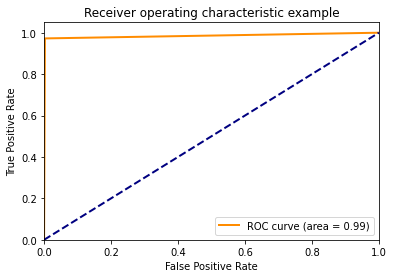

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


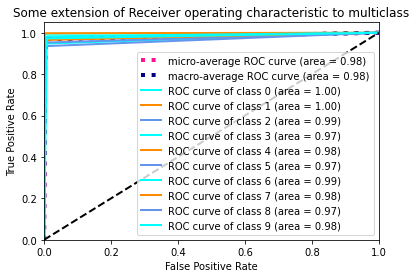

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       400
           1       0.98      1.00      0.99       400
           2       0.98      0.97      0.97       400
           3       0.95      0.95      0.95       400
           4       0.97      0.96      0.97       400
           5       0.95      0.95      0.95       400
           6       0.98      0.98      0.98       400
           7       0.97      0.97      0.97       400
           8       0.99      0.94      0.96       400
           9       0.93      0.97      0.95       400

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000

KNN, K=3


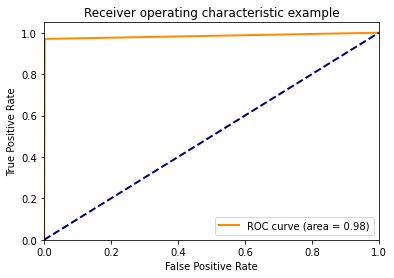

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


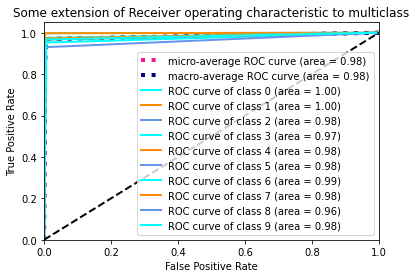

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       0.98      1.00      0.99       400
           2       0.98      0.97      0.98       400
           3       0.97      0.95      0.96       400
           4       0.98      0.97      0.97       400
           5       0.95      0.97      0.96       400
           6       0.98      0.97      0.98       400
           7       0.96      0.97      0.97       400
           8       0.98      0.93      0.95       400
           9       0.94      0.97      0.95       400

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000

SVM: 


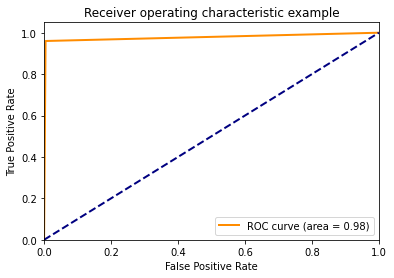

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


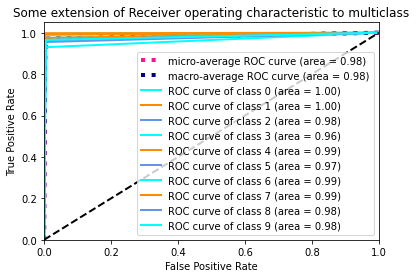

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.99      1.00      0.99       400
           2       0.96      0.96      0.96       400
           3       0.96      0.93      0.95       400
           4       0.97      0.99      0.98       400
           5       0.95      0.95      0.95       400
           6       0.98      0.97      0.98       400
           7       0.98      0.97      0.98       400
           8       0.96      0.96      0.96       400
           9       0.95      0.96      0.96       400

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000

MLP: 


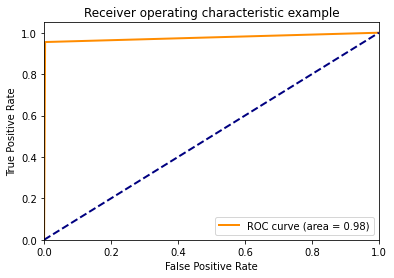

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


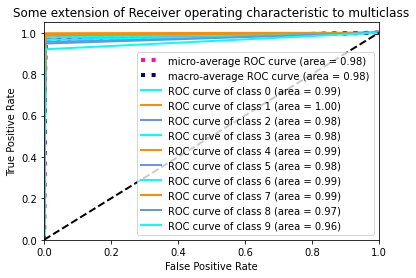

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       400
           1       0.99      1.00      0.99       400
           2       0.97      0.95      0.96       400
           3       0.95      0.96      0.96       400
           4       0.96      0.99      0.97       400
           5       0.96      0.97      0.97       400
           6       0.97      0.98      0.97       400
           7       0.96      0.99      0.97       400
           8       0.99      0.95      0.97       400
           9       0.99      0.92      0.95       400

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000

ADA: 


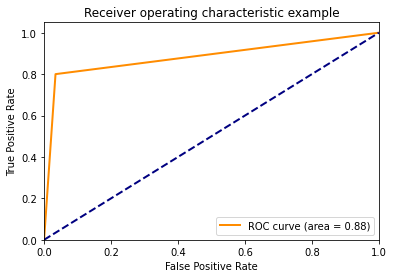

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


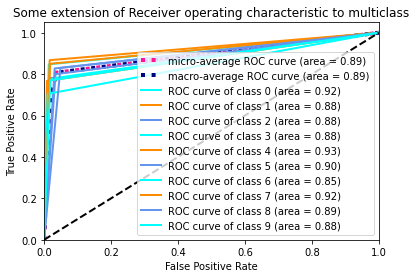

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       400
           1       0.91      0.77      0.83       400
           2       0.72      0.80      0.76       400
           3       0.85      0.78      0.81       400
           4       0.85      0.87      0.86       400
           5       0.74      0.83      0.78       400
           6       0.88      0.70      0.78       400
           7       0.84      0.85      0.84       400
           8       0.65      0.83      0.73       400
           9       0.82      0.77      0.79       400

    accuracy                           0.80      4000
   macro avg       0.81      0.80      0.81      4000
weighted avg       0.81      0.80      0.81      4000



In [248]:
# KNN, K=1
print("KNN, K=1")
performance_metrics(y_test, y_pred_knn_k1)

# KNN, K=3
print("KNN, K=3")
performance_metrics(y_test, y_pred_knn_bestk)

# SVM
print("SVM: ")
performance_metrics(y_test, y_pred_svm)

# MLP
print("MLP: ")
performance_metrics(y_test, y_pred_mlp)

# ADA
print("ADA: ")
performance_metrics(y_test, y_pred_ada)